In [24]:
import os
import pandas as pd
import wordcloud


In [12]:
base_directory = "/Users/harrywilson/Desktop/DataScienceToolbox/Assessment2Data"

In [13]:
import chardet

file_path = f"{base_directory}/artists.dat"
with open(file_path, "rb") as f:
    result = chardet.detect(f.read(10000))  # Analyze the first 10KB
    print(result)


{'encoding': 'utf-8', 'confidence': 0.87625, 'language': ''}


In [14]:
# Function to load data
def load_data(filename):
    file_path = f"{base_directory}/{filename}"
    return pd.read_csv(file_path, sep="\t", header=0)  # sep="\t" for tab-separated, header=0 means first row is the header

In [15]:
# Load the dataset
artists_file = os.path.join(base_directory, "artists.dat")
tags_file = os.path.join(base_directory, "tags.dat")
user_artists_file = os.path.join(base_directory, "user_artists.dat")
user_taggedartists_file = os.path.join(base_directory, "user_taggedartists.dat")

In [16]:
# Load the datasets
artists = pd.read_csv(artists_file, sep="\t", header=0)
tags = pd.read_csv(tags_file, sep="\t", header=0, encoding="latin-1")
user_artists = pd.read_csv(user_artists_file, sep="\t", header=0)
user_taggedartists = pd.read_csv(user_taggedartists_file, sep="\t", header=0)

In [17]:
# Display a preview of the data
print(artists.head())
print(tags.head())
print(user_artists.head())
print(user_taggedartists.head())

   id               name                                         url  \
0   1       MALICE MIZER       http://www.last.fm/music/MALICE+MIZER   
1   2    Diary of Dreams    http://www.last.fm/music/Diary+of+Dreams   
2   3  Carpathian Forest  http://www.last.fm/music/Carpathian+Forest   
3   4       Moi dix Mois       http://www.last.fm/music/Moi+dix+Mois   
4   5        Bella Morte        http://www.last.fm/music/Bella+Morte   

                                          pictureURL  
0    http://userserve-ak.last.fm/serve/252/10808.jpg  
1  http://userserve-ak.last.fm/serve/252/3052066.jpg  
2  http://userserve-ak.last.fm/serve/252/40222717...  
3  http://userserve-ak.last.fm/serve/252/54697835...  
4  http://userserve-ak.last.fm/serve/252/14789013...  
   tagID           tagValue
0      1              metal
1      2  alternative metal
2      3          goth rock
3      4        black metal
4      5        death metal
   userID  artistID  weight
0       2        51   13883
1       2    

In [19]:
# Join user_taggedartists with tags for tag information
artist_tags_df = user_taggedartists.merge(tags, on="tagID", how="inner")

# Join the result with artists to get artist details and tag names
artist_tags_info_df = artist_tags_df.merge(artists, left_on="artistID", right_on="id")

# Aggregate tags for each artist into a list and remove duplicates
artist_profiles_df = (
    artist_tags_info_df.groupby(["artistID", "name"])["tagValue"]
    .apply(lambda tags: list(set(tags)))  # Remove duplicates and collect tags
    .reset_index()
    .rename(columns={"name": "artist_name", "tagValue": "tags"})
)

# Display artist profiles
print(artist_profiles_df.head())


   artistID        artist_name  \
0         1       MALICE MIZER   
1         2    Diary of Dreams   
2         3  Carpathian Forest   
3         4       Moi dix Mois   
4         5        Bella Morte   

                                                tags  
0  [visual kei, gothic, j-rock, better than lady ...  
1  [ambient, dark, darkwave, german, gothic, elec...  
2  [norwegian black metal, true norwegian black m...  
3  [rock, visual kei, bazarov, gothic, gothic met...  
4  [darkwave, gothic, deathrock, covers, gothic r...  


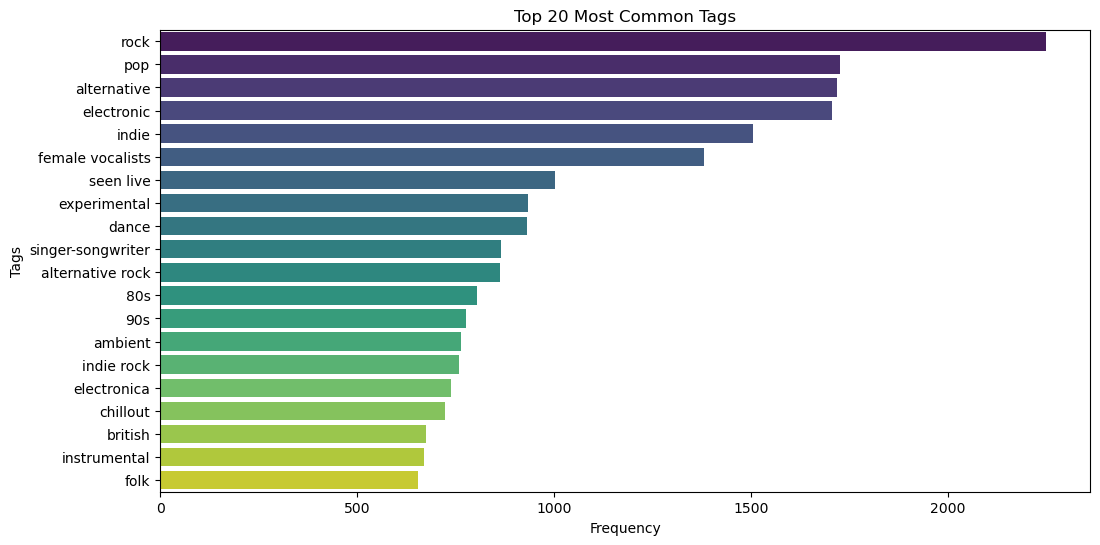

In [ ]:
# Bar chart for most common tags

import matplotlib.pyplot as plt
import seaborn as sns

# Flatten all tags into a single list and count occurrences
all_tags = [tag for tags_list in artist_profiles_df["tags"] for tag in tags_list]
tag_counts = pd.Series(all_tags).value_counts().head(20)

# Plot the top 20 tags
plt.figure(figsize=(12, 6))
sns.barplot(x=tag_counts.values, y=tag_counts.index, palette="viridis")
plt.title("Top 20 Most Common Tags")
plt.xlabel("Frequency")
plt.ylabel("Tags")
plt.show()

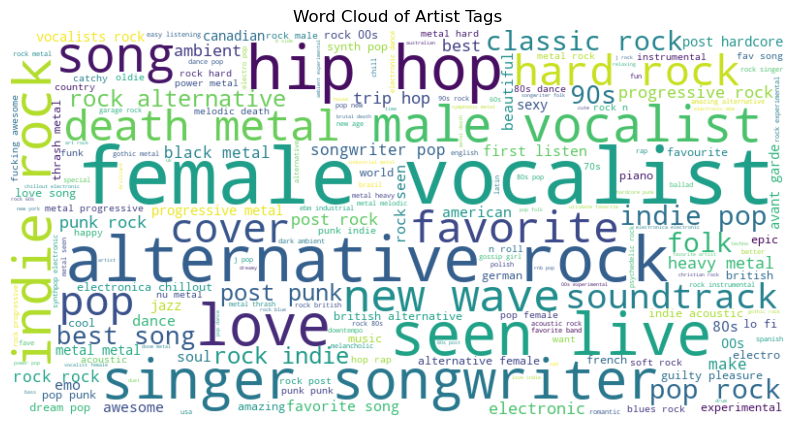

In [25]:
# Word Cloud for Tags

from wordcloud import WordCloud

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(all_tags))

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Artist Tags")
plt.show()


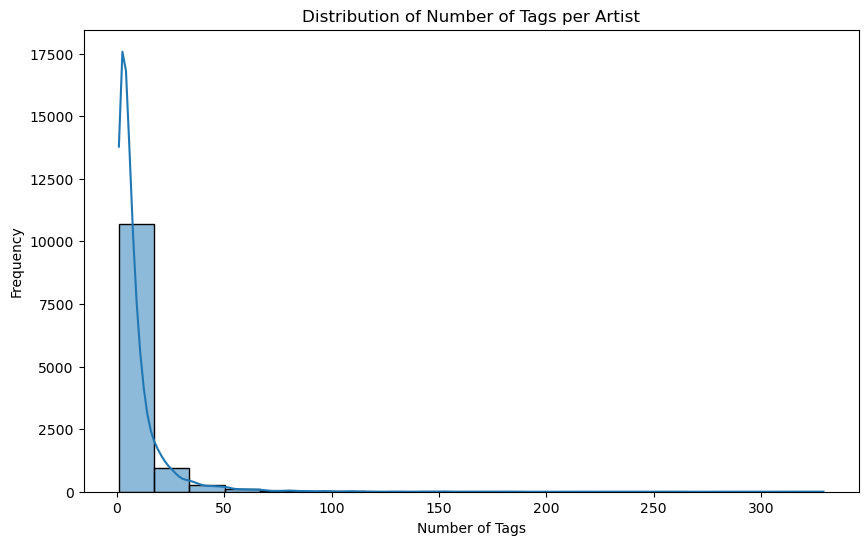

In [26]:
# Calculate the number of tags per artist
artist_profiles_df["tag_count"] = artist_profiles_df["tags"].apply(len)

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(artist_profiles_df["tag_count"], bins=20, kde=True)
plt.title("Distribution of Number of Tags per Artist")
plt.xlabel("Number of Tags")
plt.ylabel("Frequency")
plt.show()


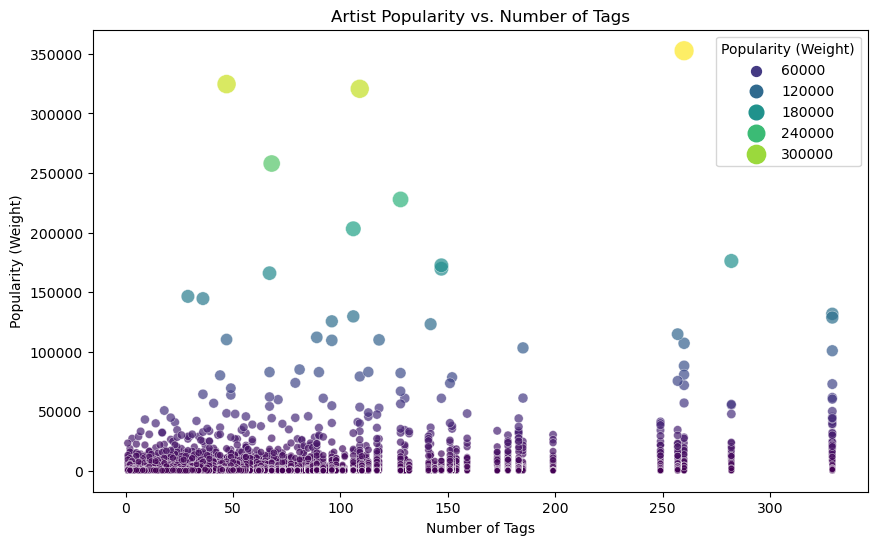

In [ ]:
# Artist Popularity vs Number of Tags

import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the number of tags per artist
artist_profiles_df["tag_count"] = artist_profiles_df["tags"].apply(len)

# Merge with user_artists to get popularity (weight)
artist_popularity_df = artist_profiles_df.merge(user_artists, on="artistID", how="inner")

# Plot scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=artist_popularity_df,
    x="tag_count",
    y="weight",
    hue="weight",  # Color points by popularity
    palette="viridis",
    size="weight",
    sizes=(20, 200),
    alpha=0.7
)
plt.title("Artist Popularity vs. Number of Tags")
plt.xlabel("Number of Tags")
plt.ylabel("Popularity (Weight)")
plt.legend(title="Popularity (Weight)")
plt.show()


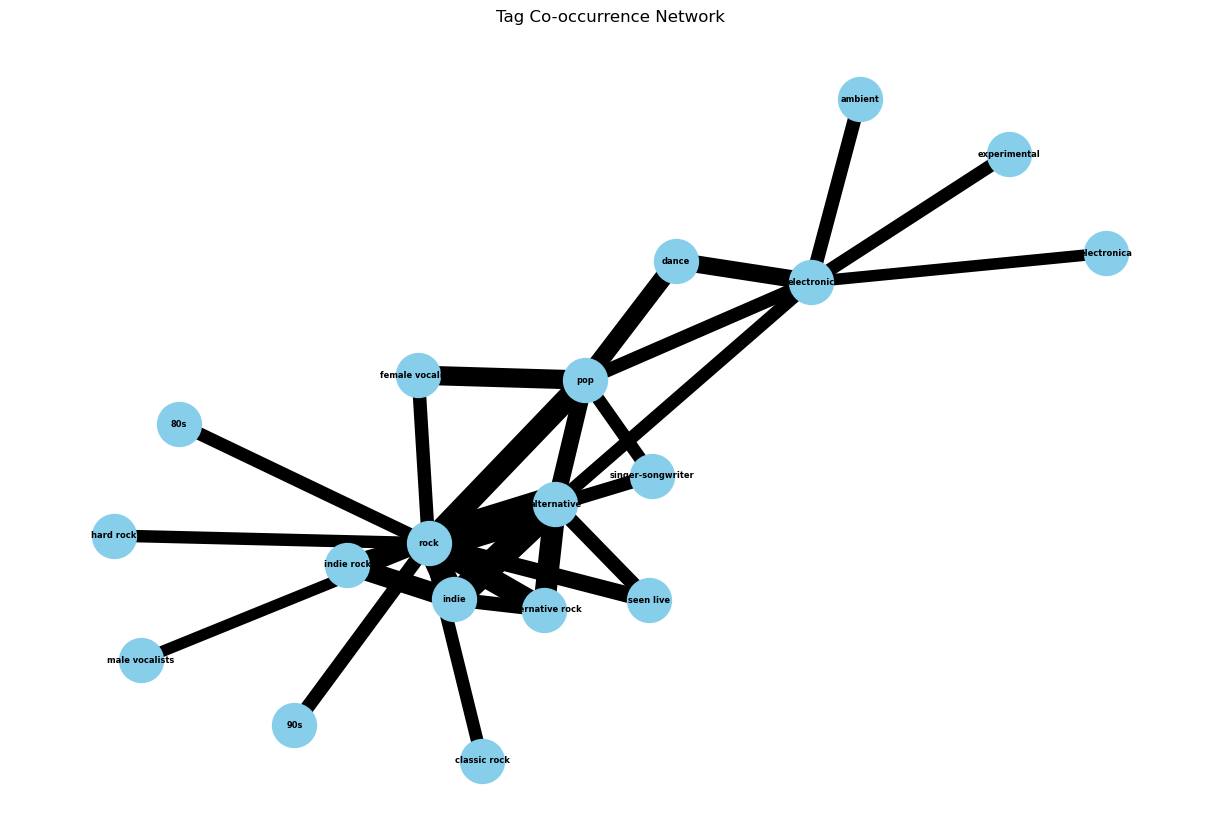

In [38]:
import itertools
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt



# Create tag pairs for each artist
tag_pairs_list = artist_profiles_df["tags"].apply(lambda tags: list(itertools.combinations(tags, 2)))

# Flatten the list of tag pairs and create a DataFrame
tag_pairs_flat = [pair for pairs in tag_pairs_list for pair in pairs]
tag_pairs_df = pd.DataFrame(tag_pairs_flat, columns=["tag1", "tag2"])

# Count the occurrence of each tag pair
tag_pair_counts = tag_pairs_df.value_counts().reset_index(name="weight")
tag_pair_counts = tag_pair_counts.nlargest(30, "weight")  # Adjust K based on desired detail level


# Create a graph using NetworkX
G = nx.Graph()

# Add edges with weights
for _, row in tag_pair_counts.iterrows():
    G.add_edge(row["tag1"], row["tag2"], weight=row["weight"])

# Draw the network graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.3)  # Layout for better spacing
edges = G.edges(data=True)

nx.draw(
    G, pos,
    node_size=1000,
    node_color='skyblue',
    font_size=6,
    font_weight='bold',
    with_labels=True
)

# Draw edges with thickness based on weight
nx.draw_networkx_edges(
    G, pos,
    edgelist=edges,
    width=[edge[2]['weight'] / 40 for edge in edges],  # Adjust edge width based on weight
)

plt.title("Tag Co-occurrence Network")
plt.show()
